In [10]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
pd.set_option('display.max_columns', None)

In [12]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [13]:
agg_strats = ['mean','00','15','30','45','min','max','std','median']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [14]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

In [15]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb = XGBRegressor(
    colsample_bytree = 0.5,
    learning_rate = 0.027241290792600834,
    max_depth = 10,
    min_child_weight = 7.790464241185818,
    n_estimators = 200,
    reg_alpha = 0.0,
    reg_lambda = 0.0)

status_saver = StatusSaver()
# build the pipeline
xgb_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', status_saver),
    ('estimator', xgb)
])

model = xgb_pipe

categorical_features: ['building_id']
impute_features: ['delta_forecast', 'mean_ceiling_height_agl:m', 'mean_cloud_base_agl:m', 'mean_snow_density:kgm3', 'mean_effective_cloud_cover_5h_mean', 'mean_GHI_lag_-1h', 'mean_GHI_lag_1h', 'mean_temp*GHI_lag_-1h', 'mean_temp*GHI_lag_1h', '00_ceiling_height_agl:m', '00_cloud_base_agl:m', '00_snow_density:kgm3', '00_effective_cloud_cover_5h_mean', '00_GHI_lag_-1h', '00_GHI_lag_1h', '00_temp*GHI_lag_-1h', '00_temp*GHI_lag_1h', '15_ceiling_height_agl:m', '15_cloud_base_agl:m', '15_snow_density:kgm3', '15_effective_cloud_cover_5h_mean', '15_GHI_lag_-1h', '15_GHI_lag_1h', '15_temp*GHI_lag_-1h', '15_temp*GHI_lag_1h', '30_ceiling_height_agl:m', '30_cloud_base_agl:m', '30_snow_density:kgm3', '30_effective_cloud_cover_5h_mean', '30_GHI_lag_-1h', '30_GHI_lag_1h', '30_temp*GHI_lag_-1h', '30_temp*GHI_lag_1h', '45_ceiling_height_agl:m', '45_cloud_base_agl:m', '45_snow_density:kgm3', '45_effective_cloud_cover_5h_mean', '45_GHI_lag_-1h', '45_GHI_lag_1h', '45_t

In [16]:
model.fit(X_train_agg, y_train_agg)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'mean_ceiling_height_agl:m',
                                                   'mean_cloud_base_agl:m',
                                                   'mean_snow_density:kgm3',
                                                   'mean_effective_cloud_cover_5h_mean',
                                                   'mean_GHI_lag_-1h',
                                                   'mean_GHI_lag_1h',
                                                   'mean_temp*GHI_lag_-1h',
                                                   'mean_te...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.027241290792600834, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None,
                              min_child_weight=7.790464241185818, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [17]:
pred = pd.Series(model.predict(X_test_agg))

In [18]:
mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
print(f'MAE: {mae}')

MAE: 147.1775836497224


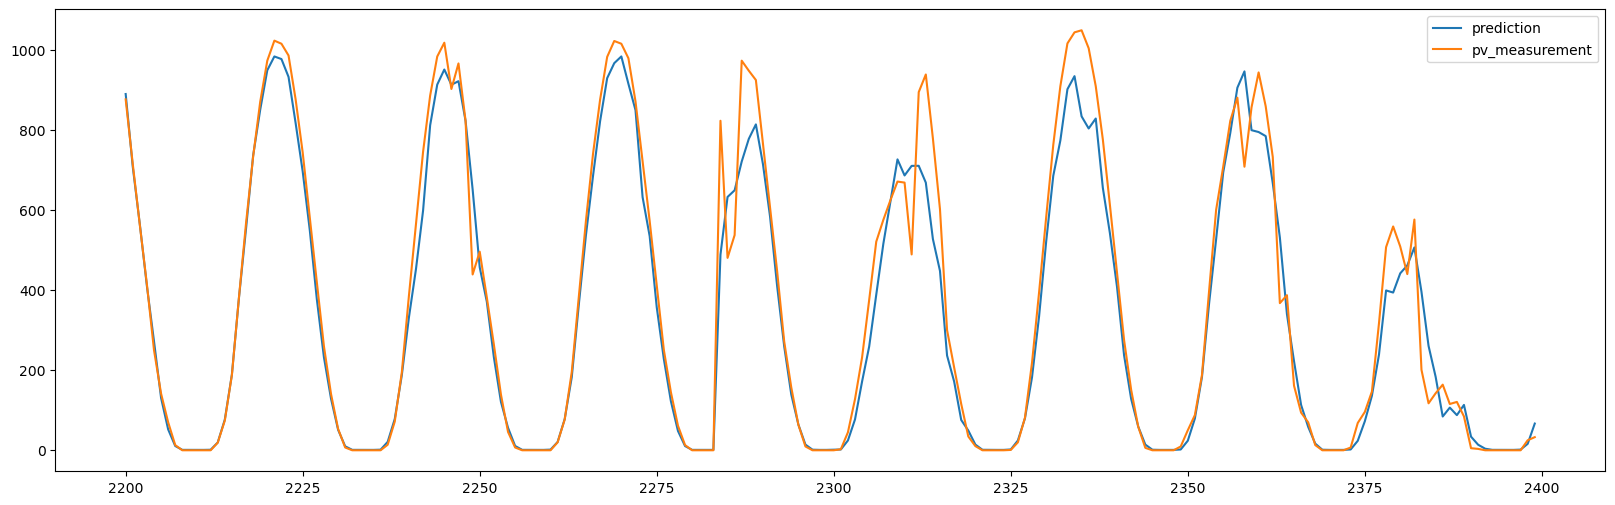

In [19]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=2200,end_idx=2400)

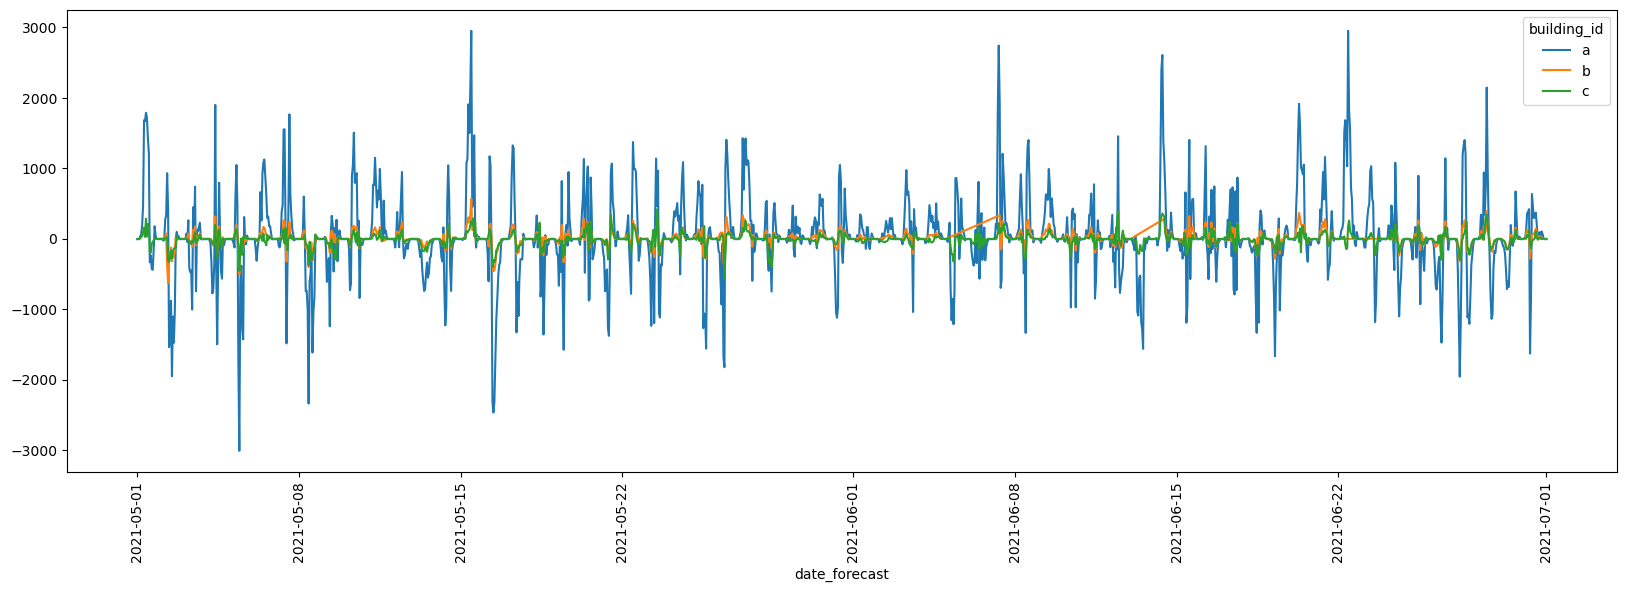

In [20]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [21]:
X_all_agg, y_all_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False, y_scaled=True)
X_all_agg = X_all_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])


In [22]:
model.fit(X_all_agg, y_all_agg)

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'mean_ceiling_height_agl:m',
                                                   'mean_cloud_base_agl:m',
                                                   'mean_snow_density:kgm3',
                                                   'mean_effective_cloud_cover_5h_mean',
                                                   'mean_GHI_lag_-1h',
                                                   'mean_GHI_lag_1h',
                                                   'mean_temp*GHI_lag_-1h',
                                                   'mean_te...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.027241290792600834, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None,
                              min_child_weight=7.790464241185818, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [23]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='new_aggregation.csv',sun_el_thr=-1)

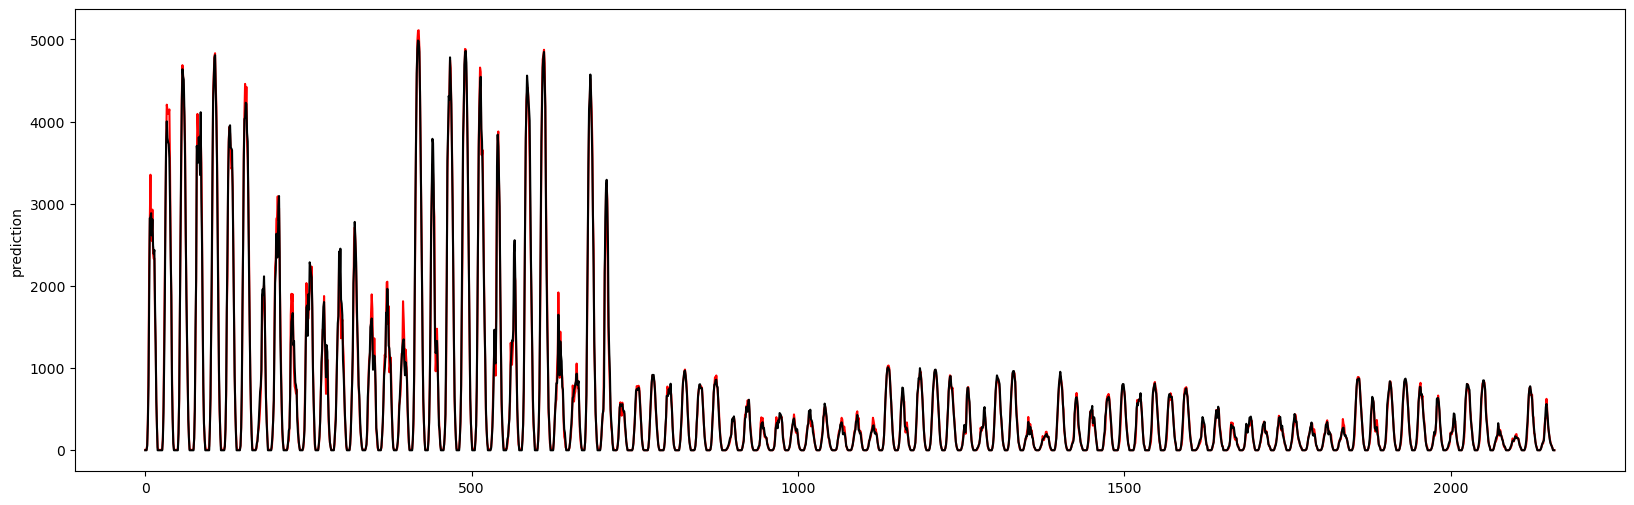

In [24]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')